![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/2.Clinical_Assertion_Model.ipynb)

# Clinical Assertion Status Model

## Colab Setup

In [1]:
import json

with open('workshop_license_keys_Aug2020.json') as f:
    license_keys = json.load(f)

license_keys.keys()


dict_keys(['JSL_VERSION', 'PUBLIC_VERSION', 'SECRET', 'SPARK_NLP_LICENSE', 'AWS_ACCESS_KEY_ID', 'AWS_SECRET_ACCESS_KEY', 'JSL_OCR_SECRET', 'SPARK_OCR_LICENSE'])

In [2]:
license_keys['JSL_VERSION']

'2.5.4rc3'

In [3]:
# template for license_key.json

{'JSL_VERSION':'jjj',
'PUBLIC_VERSION':'vvv',
'SECRET':"xxx",
'SPARK_NLP_LICENSE': 'aaa',
'JSL_OCR_LICENSE': 'bbb',
'AWS_ACCESS_KEY_ID':"ccc",
'AWS_SECRET_ACCESS_KEY':"ddd",
'JSL_OCR_SECRET':"eee"}

{'AWS_ACCESS_KEY_ID': 'ccc',
 'AWS_SECRET_ACCESS_KEY': 'ddd',
 'JSL_OCR_LICENSE': 'bbb',
 'JSL_OCR_SECRET': 'eee',
 'JSL_VERSION': 'jjj',
 'PUBLIC_VERSION': 'vvv',
 'SECRET': 'xxx',
 'SPARK_NLP_LICENSE': 'aaa'}

In [ ]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

secret = license_keys['SECRET']

os.environ['SPARK_NLP_LICENSE'] = license_keys['SPARK_NLP_LICENSE']
os.environ['SPARK_OCR_LICENSE'] = license_keys['SPARK_OCR_LICENSE']
os.environ['AWS_ACCESS_KEY_ID']= license_keys['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = license_keys['AWS_SECRET_ACCESS_KEY']
jsl_version = license_keys['JSL_VERSION']
version = license_keys['PUBLIC_VERSION']

! pip install --ignore-installed -q pyspark==2.4.4

! python -m pip install --upgrade spark-nlp-jsl==$jsl_version  --extra-index-url https://pypi.johnsnowlabs.com/$secret

! pip install --ignore-installed -q spark-nlp==$version

import sparknlp

print (sparknlp.version())

import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl

spark = sparknlp_jsl.start(secret)

In [ ]:
# if you want to start the session with custom params as in start function above
def start(secret):
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "16G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2000M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:"+version) \
        .config("spark.jars", "https://pypi.johnsnowlabs.com/"+secret+"/spark-nlp-jsl-"+jsl_version+".jar")
      
    return builder.getOrCreate()

#spark = start(secret)

In [ ]:
spark

# Clinical Assertion Model (with pretrained models)

In [5]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP

from sparknlp_jsl.annotator import *

documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line

sentenceDetector = SentenceDetector()\
  .setInputCols(["document"])\
  .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

# NER model trained on i2b2 (sampled from MIMIC) dataset
clinical_ner = NerDLModel.pretrained("ner_clinical", "en", "clinical/models") \
  .setInputCols(["sentence", "token", "embeddings"]) \
  .setOutputCol("ner")

ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")

# Assertion model trained on i2b2 (sampled from MIMIC) dataset
# coming from sparknlp_jsl.annotator !!
clinical_assertion = AssertionDLModel.pretrained("assertion_dl", "en", "clinical/models") \
    .setInputCols(["sentence", "ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")
    
nlpPipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    ner_converter,
    clinical_assertion
    ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
[OK!]


In [ ]:
# we also have a LogReg based Assertion Model.
'''
clinical_assertion_ml = AssertionLogRegModel.pretrained("assertion_ml", "en", "clinical/models") \
    .setInputCols(["sentence", "ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")
'''

'\nclinical_assertion_ml = AssertionLogRegModel.pretrained("assertion_ml", "en", "clinical/models")     .setInputCols(["sentence", "ner_chunk", "embeddings"])     .setOutputCol("assertion")\n'

In [25]:
import pandas as pd

text = 'Patient has a headache for the last 2 weeks and appears anxious when she walks fast. No alopecia noted. She denies pain'

print (text)

light_model = LightPipeline(model)

light_result = light_model.fullAnnotate(text)[0]

chunks=[]
entities=[]
status=[]

for n,m in zip(light_result['ner_chunk'],light_result['assertion']):
    
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    status.append(m.result)
        
df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

df

Patient has a headache for the last 2 weeks and appears anxious when she walks fast. No alopecia noted. She denies pain


chunks entities    assertion
0  a headache  PROBLEM      present
1     anxious  PROBLEM  conditional
2    alopecia  PROBLEM       absent
3        pain  PROBLEM       absent

In [6]:
! wget 	https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/pubmed/pubmed_sample_text_small.csv


--2020-08-03 21:54:38--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/pubmed/pubmed_sample_text_small.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.1.254
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.1.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9363435 (8.9M) [text/csv]
Saving to: ‘pubmed_sample_text_small.csv’

pubmed_sample_text_ 100%[===================>]   8.93M  15.8MB/s    in 0.6s    

2020-08-03 21:54:39 (15.8 MB/s) - ‘pubmed_sample_text_small.csv’ saved [9363435/9363435]



In [7]:
import pyspark.sql.functions as F

pubMedDF = spark.read\
                .option("header", "true")\
                .csv("pubmed_sample_text_small.csv")\
                
pubMedDF.show(truncate=50)

+--------------------------------------------------+
|                                              text|
+--------------------------------------------------+
|The human KCNJ9 (Kir 3.3, GIRK3) is a member of...|
|BACKGROUND: At present, it is one of the most i...|
|OBJECTIVE: To investigate the relationship betw...|
|Combined EEG/fMRI recording has been used to lo...|
|Kohlschutter syndrome is a rare neurodegenerati...|
|Statistical analysis of neuroimages is commonly...|
|The synthetic DOX-LNA conjugate was characteriz...|
|Our objective was to compare three different me...|
|We conducted a phase II study to assess the eff...|
|"""Monomeric sarcosine oxidase (MSOX) is a flav...|
|We presented the tachinid fly Exorista japonica...|
|The literature dealing with the water conductin...|
|A novel approach to synthesize chitosan-O-isopr...|
|An HPLC-ESI-MS-MS method has been developed for...|
|The localizing and lateralizing values of eye a...|
|OBJECTIVE: To evaluate the effectiveness and 

In [8]:
result = model.transform(pubMedDF.limit(100))

In [9]:
result.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|           assertion|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|The human KCNJ9 (...|[[document, 0, 95...|[[document, 0, 12...|[[token, 0, 2, Th...|[[word_embeddings...|[[named_entity, 0...|[[chunk, 17, 19, ...|[[assertion, 17, ...|
|BACKGROUND: At pr...|[[document, 0, 14...|[[document, 0, 19...|[[token, 0, 9, BA...|[[word_embeddings...|[[named_entity, 0...|[[chunk, 67, 79, ...|[[assertion, 67, ...|
|OBJECTIVE: To inv...|[[document, 0, 15...|[[document, 0, 30...|[[token, 0, 8, OB...|[[word_embeddings...|[[named_entity, 0...|[[chunk, 130, 152...|[[

In [12]:
result.select('sentence.result').take(3)

[Row(result=['The human KCNJ9 (Kir 3.3, GIRK3) is a member of the G-protein-activated inwardly rectifying potassium (GIRK) channel family.', 'Here we describe the genomicorganization of the KCNJ9 locus on chromosome 1q21-23 as a candidate gene forType II diabetes mellitus in the Pima Indian population.', 'The gene spansapproximately 7.6 kb and contains one noncoding and two coding exons separated byapproximately 2.2 and approximately 2.6 kb introns, respectively.', 'We identified14 single nucleotide polymorphisms (SNPs), including one that predicts aVal366Ala substitution, and an 8 base-pair', '(bp) insertion/deletion.', 'Ourexpression studies revealed the presence of the transcript in various humantissues including pancreas, and two major insulin-responsive tissues: fat andskeletal muscle.', 'The characterization of the KCNJ9 gene should facilitate furtherstudies on the function of the KCNJ9 protein and allow evaluation of thepotential role of the locus in Type II diabetes.']),
 Row(r

In [11]:
result.select(F.explode(F.arrays_zip('ner_chunk.result',  'ner_chunk.begin', 'ner_chunk.end', 'ner_chunk.metadata', 'assertion.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("chunk"),
        F.expr("cols['1']").alias("begin"),
        F.expr("cols['2']").alias("end"),
        F.expr("cols['3']['entity']").alias("ner_label"),
        F.expr("cols['3']['sentence']").alias("sent_id"),
        F.expr("cols['4']").alias("assertion"),).show(truncate=False)


+---------------------------------------------+-----+---+---------+-------+---------+
|chunk                                        |begin|end|ner_label|sent_id|assertion|
+---------------------------------------------+-----+---+---------+-------+---------+
|Kir                                          |17   |19 |TEST     |0      |present  |
|GIRK3                                        |26   |30 |TEST     |0      |present  |
|chromosome 1q21-23                           |188  |205|TREATMENT|1      |present  |
|a candidate gene forType II diabetes mellitus|210  |254|PROBLEM  |1      |possible |
|coding exons                                 |357  |368|TEST     |2      |absent   |
|byapproximately                              |380  |394|TEST     |2      |present  |
|introns                                      |425  |431|TEST     |2      |absent   |
|single nucleotide polymorphisms (SNPs        |464  |500|PROBLEM  |3      |present  |
|aVal366Ala substitution                      |532  |5

## Writing a generic Assertion + NER function

In [26]:
from pyspark.sql.functions import monotonically_increasing_id


def get_base_pipeline (embeddings = 'embeddings_clinical'):

  documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

  # Sentence Detector annotator, processes various sentences per line

  sentenceDetector = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

  # Tokenizer splits words in a relevant format for NLP

  tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

  # Clinical word embeddings trained on PubMED dataset
  word_embeddings = WordEmbeddingsModel.pretrained(embeddings, "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

  empty_data = spark.createDataFrame([[""]]).toDF("text")

  model = nlpPipeline.fit(empty_data)

  return model



def get_clinical_assertion (embeddings, spark_df, nrows = 100, model_name = 'ner_clinical'):

  # NER model trained on i2b2 (sampled from MIMIC) dataset
  loaded_ner_model = NerDLModel.pretrained(model_name, "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

  ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")

  # Assertion model trained on i2b2 (sampled from MIMIC) dataset
  # coming from sparknlp_jsl.annotator !!
  clinical_assertion = AssertionDLModel.pretrained("assertion_dl", "en", "clinical/models") \
      .setInputCols(["sentence", "ner_chunk", "embeddings"]) \
      .setOutputCol("assertion")
      

  base_model = get_base_pipeline (embeddings)

  nlpPipeline = Pipeline(stages=[
      base_model,
      loaded_ner_model,
      ner_converter])

  empty_data = spark.createDataFrame([[""]]).toDF("text")

  model = nlpPipeline.fit(empty_data)

  result = model.transform(spark_df.limit(nrows))

  result = result.withColumn("id", monotonically_increasing_id())

  result_df = result.select(F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.metadata', 'assertion.result')).alias("cols")) \
  .select(F.expr("cols['0']").alias("chunk"),
        F.expr("cols['1']['entity']").alias("ner_label"),
        F.expr("cols['2']").alias("assertion"))\
        .filter("ner_label!='O'")

  return result_df

In [27]:
embeddings = 'embeddings_clinical'

model_name = 'ner_clinical'

nrows = 100

ner_df = get_clinical_assertion (embeddings, pubMedDF, nrows, model_name)

ner_df.show()

ner_clinical download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
+--------------------+---------+---------+
|               chunk|ner_label|assertion|
+--------------------+---------+---------+
|                 Kir|     TEST|  present|
|               GIRK3|     TEST|  present|
|  chromosome 1q21-23|TREATMENT|  present|
|a candidate gene ...|  PROBLEM| possible|
|        coding exons|     TEST|   absent|
|     byapproximately|     TEST|  present|
|             introns|     TEST|   absent|
|single nucleotide...|  PROBLEM|  present|
|aVal366Ala substi...|TREATMENT|  present|
|      an 8 base-pair|  PROBLEM|  present|
|                 bp)|     TEST|  present|
|Ourexpression stu...|     TEST|  present|
|The characterizat...|     TEST|  present|
|      furthe

In [28]:
embeddings = 'embeddings_clinical'

model_name = 'ner_posology'

nrows = 100

ner_df = get_clinical_assertion (embeddings, pubMedDF, nrows, model_name)

ner_df.show()

ner_posology download started this may take some time.
Approximate size to download 13.7 MB
[OK!]
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
+----------------+---------+---------+
|           chunk|ner_label|assertion|
+----------------+---------+---------+
|  anthracyclines|     DRUG|  present|
|         taxanes|     DRUG|  present|
|     vinorelbine|     DRUG|  present|
|     vinorelbine|     DRUG|  present|
|  anthracyclines|     DRUG|  present|
|         taxanes|     DRUG| possible|
|  Vinorelbinewas|     DRUG|  present|
|       25 mg/m(2| STRENGTH|  present|
|   intravenously|    ROUTE|  present|
|         on days|FREQUENCY|  present|
|tumorprogression|     DRUG|  present|
| thatvinorelbine|     DRUG|  present|
|  anthracyclines|     DRUG|  present|
|         taxanes|     DRUG|   absent|
| tetrazolium dye|     DRUG|  present|

In [29]:
embeddings = 'embeddings_clinical'

model_name = 'ner_posology'

entry_data = spark.createDataFrame([["The patient didn't take a capsule of Advil"]]).toDF("text")

ner_df = get_clinical_assertion (embeddings, entry_data, nrows, model_name)

ner_df.show()

ner_posology download started this may take some time.
Approximate size to download 13.7 MB
[OK!]
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
+-------+---------+---------+
|  chunk|ner_label|assertion|
+-------+---------+---------+
|capsule|     FORM|  present|
|  Advil|     DRUG|     null|
+-------+---------+---------+



In [30]:
import pandas as pd

def get_clinical_assertion_light (light_model, text):

  light_result = light_model.fullAnnotate(text)[0]

  chunks=[]
  entities=[]
  status=[]

  for n,m in zip(light_result['ner_chunk'],light_result['assertion']):
      
      chunks.append(n.result)
      entities.append(n.metadata['entity']) 
      status.append(m.result)
          
  df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

  return df

In [31]:
clinical_text = """
Patient with severe fever and sore throat. 
He shows no stomach pain and he maintained on an epidural and PCA for pain control.
He also became short of breath with climbing a flight of stairs.
After CT, lung tumor located at the right lower lobe. Father with Alzheimer.
"""

light_model = LightPipeline(model)

get_clinical_assertion_light (light_model, clinical_text)


chunks   entities                     assertion
0     severe fever    PROBLEM                       present
1      sore throat    PROBLEM                       present
2     stomach pain    PROBLEM                        absent
3      an epidural  TREATMENT                       present
4              PCA  TREATMENT                       present
5     pain control    PROBLEM                       present
6  short of breath    PROBLEM                   conditional
7               CT       TEST                       present
8       lung tumor    PROBLEM                       present
9        Alzheimer    PROBLEM  associated_with_someone_else

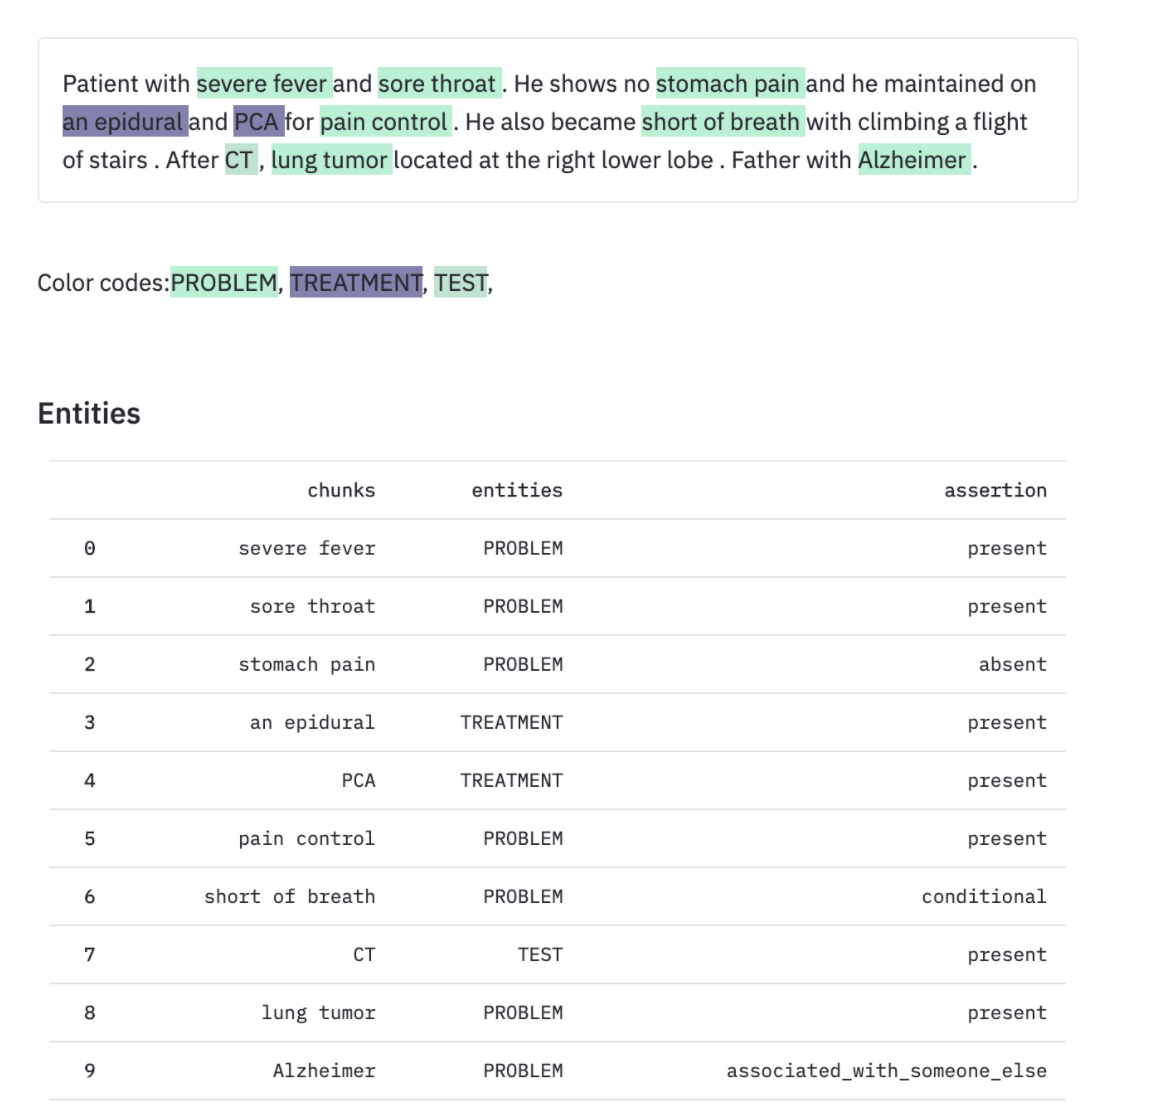

## Assertion with BioNLP (Cancer Genetics) NER

In [ ]:
embeddings = 'embeddings_clinical'

model_name = 'ner_bionlp'

nrows = 100

ner_df = get_clinical_assertion (embeddings, pubMedDF, nrows, model_name)

ner_df.show(truncate = False)

ner_bionlp download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
assertion_dl download started this may take some time.
Approximate size to download 1.3 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
+----------------------+--------------------+---------+
|chunk                 |ner_label           |assertion|
+----------------------+--------------------+---------+
|human                 |Organism            |present  |
|Kir 3.3               |Gene_or_gene_product|present  |
|GIRK3                 |Gene_or_gene_product|present  |
|potassium             |Simple_chemical     |possible |
|GIRK                  |Gene_or_gene_product|absent   |
|chromosome 1q21-23    |Cellular_component  |present  |
|pancreas              |Organ               |absent   |
|tissues               |Tissue              |present  |
|fat andskeletal muscle|Tissue              |present  |
|KCNJ9                 |Gene_or

# Train a custom Assertion Model

In [32]:
!wget https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/ner/i2b2_assertion_sample.csv

--2020-08-03 22:08:38--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/ner/i2b2_assertion_sample.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.44.246
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.44.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 141585 (138K) [text/csv]
Saving to: ‘i2b2_assertion_sample.csv’

i2b2_assertion_samp 100%[===================>] 138.27K   748KB/s    in 0.2s    

2020-08-03 22:08:38 (748 KB/s) - ‘i2b2_assertion_sample.csv’ saved [141585/141585]



In [33]:
import pandas as pd

In [34]:

assertion_df = spark.read.option("header", True).option("inferSchema", "True").csv("i2b2_assertion_sample.csv")


In [35]:
assertion_df.show(3, truncate=100)

+-----------------------------------------------------------------------------+--------------------+-------+-----+---+
|                                                                         text|              target|  label|start|end|
+-----------------------------------------------------------------------------+--------------------+-------+-----+---+
|Due to dye load required to assess the coronary disease were not visualized .|the coronary disease|present|    7|  9|
|                            She has no history of liver disease , hepatitis .|       liver disease| absent|    5|  6|
|                                                     1. Undesired fertility .| undesired fertility|present|    1|  2|
+-----------------------------------------------------------------------------+--------------------+-------+-----+---+
only showing top 3 rows



In [36]:
(training_data, test_data) = assertion_df.randomSplit([0.8, 0.2], seed = 100)
print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 796
Test Dataset Count: 204


In [48]:
training_data.groupBy('label').count().orderBy('count', ascending=False).show(truncate=False)


+----------------------------+-----+
|label                       |count|
+----------------------------+-----+
|present                     |529  |
|absent                      |184  |
|hypothetical                |37   |
|possible                    |36   |
|associated_with_someone_else|6    |
|conditional                 |4    |
+----------------------------+-----+



In [37]:

document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

chunk = Doc2Chunk()\
    .setInputCols("document")\
    .setOutputCol("chunk")\
    .setChunkCol("target")\
    .setStartCol("start")\
    .setStartColByTokenIndex(True)\
    .setFailOnMissing(False)\
    .setLowerCase(True)

token = Tokenizer()\
    .setInputCols(['document'])\
    .setOutputCol('token')

embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
      .setInputCols(["document", "token"])\
      .setOutputCol("embeddings")


embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


In [ ]:
!mkdir training_logs
!mkdir tf_graphs
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/nerdl_graph/blstm_34_32_30_200_6.pb -P /content/tf_graphs

In [57]:

assertionStatus = AssertionDLApproach()\
    .setLabelCol("label")\
    .setInputCols("document", "chunk", "embeddings")\
    .setOutputCol("assertion")\
    .setBatchSize(128)\
    .setDropout(0.1)\
    .setLearningRate(0.001)\
    .setEpochs(10)\
    .setValidationSplit(0.2)\
    .setStartCol("start")\
    .setEndCol("end")\
    .setMaxSentLen(250)\
  .setClasses(6)\
.setEnableOutputLogs(True)\
.setOutputLogsPath('training_logs/')\
.setGraphFolder('tf_graphs')

# set this path to graphs if you have different nuber of classes other than 6. (use 2.1 Aseertion Model Graph generation notebook)

In [ ]:
'''
assertionStatus = AssertionLogRegApproach()\
    .setLabelCol("label")\
    .setInputCols("document", "chunk", "embeddings")\
    .setOutputCol("assertion")\
    .setMaxIter(100) # default: 26
'''

In [58]:
clinical_assertion_pipeline = Pipeline(
    stages = [
    document,
    chunk,
    token,
    embeddings,
    assertionStatus])

In [59]:
%%time

assertion_model = clinical_assertion_pipeline.fit(training_data)

CPU times: user 76.5 ms, sys: 10.4 ms, total: 86.9 ms
Wall time: 1min 48s


In [64]:
!cd training_logs && ls -lt

total 16
-rw-r--r-- 1 root root 6572 Aug  3 22:24 AssertionDLApproach_e629423217f6.log
-rw-r--r-- 1 root root 4023 Aug  3 22:19 AssertionDLApproach_313267aaaf3a.log
-rw-r--r-- 1 root root  147 Aug  3 22:15 AssertionDLApproach_8018beedba14.log


In [65]:
!cat training_logs/AssertionDLApproach_e629423217f6.log

Name of the selected graph: blstm_34_32_30_200_6.pb
Training started, trainExamples: 796
Epoch: 0 started, learning rate: 0.001, dataset size: 637
Done, 10.594825538 loss: 6.1070685, batches: 5
Quality on validation dataset (20.0%), validation examples = 159
time to finish evaluation: 1.87s
label	 tp	 fp	 fn	 prec	 rec	 f1
absent	 0	 0	 44	 0.0	 0.0	 0.0
present	 98	 61	 0	 0.6163522	 1.0	 0.7626459
conditional	 0	 0	 1	 0.0	 0.0	 0.0
associated_with_someone_else	 0	 0	 3	 0.0	 0.0	 0.0
hypothetical	 0	 0	 6	 0.0	 0.0	 0.0
possible	 0	 0	 7	 0.0	 0.0	 0.0
tp: 98 fp: 61 fn: 61 labels: 6
Macro-average	 prec: 0.102725364, rec: 0.16666667, f1: 0.12710765
Micro-average	 prec: 0.6163522, rec: 0.6163522, f1: 0.6163522
Epoch: 1 started, learning rate: 9.5E-4, dataset size: 637
Done, 8.782994488 loss: 5.1900153, batches: 5
Quality on validation dataset (20.0%), validation examples = 159
time to finish evaluation: 1.63s
label	 tp	 fp	 fn	 prec	 rec	 f1
absent	 0	 0	 44	 0.0	 0.0	 0.0
present	 98

In [60]:
preds = assertion_model.transform(test_data).select('label','assertion.result')

preds.show()

+------------+---------+
|       label|   result|
+------------+---------+
|     present|[present]|
|    possible|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|hypothetical|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|     present|[present]|
|hypothetical|[present]|
|     present|[present]|
+------------+---------+
only showing top 20 rows



In [61]:
preds_df = preds.toPandas()


In [62]:
preds_df['result'] = preds_df['result'].apply(lambda x : x[0])


In [63]:
# We are going to use sklearn to evalute the results on test dataset
from sklearn.metrics import classification_report

print (classification_report(preds_df['result'], preds_df['label']))

                              precision    recall  f1-score   support

                      absent       0.45      0.83      0.59        24
associated_with_someone_else       0.00      0.00      0.00         0
                 conditional       0.00      0.00      0.00         0
                hypothetical       0.00      0.00      0.00         2
                    possible       0.00      0.00      0.00         0
                     present       0.99      0.75      0.85       178

                    accuracy                           0.75       204
                   macro avg       0.24      0.26      0.24       204
                weighted avg       0.91      0.75      0.81       204



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
